# Summary

1. immune-related gene trends match infected epithelials in pt samples
2. similar DGEs between infected and un-infected ciliated cells in pt samples
3. [x] confirm that ciliated cells are infected 

In [1]:
%matplotlib inline

import os
import time
import datetime
import glob
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scprep
import graphtools as gt
import phate
from scipy import sparse
from scipy.stats import zscore 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import warnings
from adjustText import adjust_text


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")

In [2]:
dfp = '/gpfs/ycga/sequencers/pacbio/gw92/10x/data_sent/rp475/*20/*HCR*/filtered_feature_bc_matrix/'
data_files = glob.glob(dfp)
pfp = '/home/ngr4/project/covid_lung/results/'
pdfp = '/home/ngr4/project/covid_lung/data/processed/'

def loader(fname,fpath,backed=None) : 
    start = time.time()
    adata = sc.read_h5ad(filename=os.path.join(fpath,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    return adata

def writer(fname,fpath,AnnData) :
    start = time.time()
    AnnData.write(os.path.join(fpath,fname))
    print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to save data'.format(time.time()-start))

if False :
    # load personal
    fname='bal1.h5ad'
    adata = loader(fname,pdfp)
    
if False:
    # save 
    fname='covid3balfs.h5ad'
    writer(fname, pdfp, adata)
    
if True:
    # load personal
    fname = 'covid3balfs.h5ad'
    adata = loader(fname,pdfp)

loaded @200604.12:03:35
took 2.12-s to load data


In [22]:
adata.obs['scv2_geq1'] = ((adata.raw[:,'scv2_orf1-10'].X>0).todense()).flatten().astype(int).tolist()[0]

In [35]:
# ['IFNB1', 'IFNL2', 'IFNL3'] not in dataset
genes = ['IFNL1','IFNAR1','IFNLR1','IFI27','IFITM3','IFI6','IFIT1',
         'MX1','ISG15','CCL2','CXCL9','CXCL10','CXCL11','CXCL16','IL1A','IL1B','IL1RN','IL6','IL10','TNF']

X = pd.DataFrame(np.asarray(adata[:,genes].X.todense()), 
                columns=genes)
X['Cell type'] = adata.obs['init_ctype'].astype(str).to_list()
X['Sample'] = adata.obs['Condition'].astype(str).to_list()
X['Infected'] = adata.obs['scv2_geq1'].astype(str).to_list()
X['Identity'] = X['Sample'].astype(str)+'+'+X['Cell type'].astype(str)+'+'+X['Infected'].astype(str)
X.loc[:,genes] = zscore(X.loc[:,genes])

X['Identity'] = X['Identity'].astype('category')
X = X.sort_values(by='Identity')

ave_zscore = X.groupby('Identity').mean().T

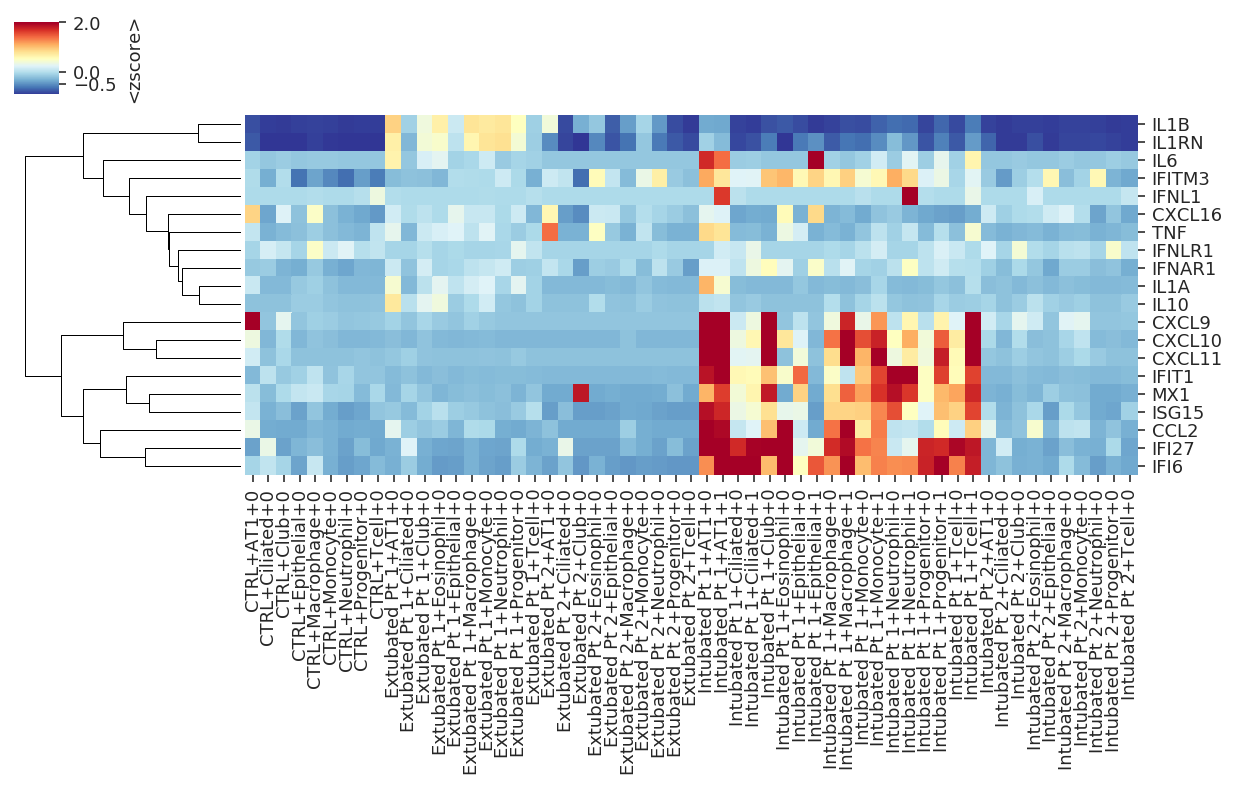

In [47]:
# HEATMAP

p = sns.clustermap(
    ave_zscore,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=None,
    figsize=(10,4),
    cbar_kws={'ticks':[-0.5,0,2],'label':'<zscore>'},
    row_cluster=True,
    col_cluster=False,
    row_linkage=None,
    col_linkage=None,
    row_colors=None,
    col_colors=None,
    mask=None,
    cmap='RdYlBu_r',
    yticklabels=True,
    xticklabels=True,
    vmax=2,
#     vmin=-2,vmax=2,
)
p.ax_heatmap.set_xlabel('')
if True:
    p.savefig(os.path.join(pfp,'heatmap_hbec_goi.png'),dpi=300,bbox_inches='tight')